# **TMDB MOVIE DATA ANALYSIS USING PYSPARK**

This project extracts movie data from the TMDB API, cleans and preprocesses the dataset, and performs in-depth exploratory data analysis. The goal is to uncover meaningful insights, identify trends, and support data-driven decision-making based on movie performance, audience behavior, and industry patterns.

## **IMPORTS LIBRARIES**

In [1]:
#Import os and sys
import os
import sys 
from pathlib import Path
import ast
import pandas as pd
import numpy as np

#Spark imports
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *

sys.path

#Imports loadEnv from config module
from config.config import loadEnv, getURL, create_retry

#Imports extractDataFromAPI from the extract data module
from Data_Extraction.extractData import extractDataFromAPI
from Data_Cleaning.removeColumns import dropColumns
from Data_Cleaning.convertArray import separateArrayColumn
from Data_Analysis.dataVisualization import trendVisuals, plot_yearly_box_office_trends, plot_franchise_vs_standalone_metrics, plot_roi_by_genre
from src.preprocessing import preprocessing

## **PYSPARK CONFIGUARTION**

In [2]:
"""
    Adaptive Query Execution (AQE): Dynamically optimizes query plans at runtime
    Coalesce Partitions: Reduces number of partitions for small datasets automatically

"""
spark = (
    SparkSession.builder
    .appName("TMDB Movie Data Analysis")
    .master("local[*]")
    .config("spark.sql.adaptive.enabled", "true") 
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true")
    .getOrCreate()
)

# Set display options for better debugging
#Eager Eval: Shows DataFrames nicely in notebooks (like Pandas)
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)
spark.conf.set("spark.sql.repl.eagerEval.maxNumRows", 10)

print("Spark Session Configured Sucessfully")


Spark Session Configured Sucessfully


## **DATA EXTRACTION**

In [3]:


movie_ids = [0, 299534,19995,140607,299536,597,135397, 420818, 24428, 168259, 99861,
                    284054, 12445, 181808, 330457, 351286, 109445, 321612, 260513] 

API_KEY = loadEnv(fileName="API_KEY")

url = getURL()

session = create_retry()

extractDataFromAPI(session = session, url = url, API_KEY = API_KEY, movie_ids=movie_ids)




Raw TMDB JSON saved to ../data/raw_data/movieData.json


## **EXPLORATORY DATA ANALYSIS**

### **READS THE CSV FILE**

In [4]:
#Reads the csv file
movie_data = (
    spark.read
    .option("header", "true")
    .option("inferSchema", "true")
    .json("/data/raw_data/movieData.json")
)


### **INSPECTS DATA**

In [5]:
# Verifies the data is loaded
print("Initial Data Overview \n")
print(f"Total Records: {movie_data.count()}")
print(f"Total Columns: {len(movie_data.columns)}")

# Show sample data (first 3 rows, non-truncated for key columns)
movie_data.select("id", "title", "release_date", "genres").show(3, truncate=60)

Initial Data Overview 

Total Records: 18
Total Columns: 27
+------+----------------------------+------------+------------------------------------------------------------+
|    id|                       title|release_date|                                                      genres|
+------+----------------------------+------------+------------------------------------------------------------+
|299534|           Avengers: Endgame|  2019-04-24|     [{12, Adventure}, {878, Science Fiction}, {28, Action}]|
| 19995|                      Avatar|  2009-12-16|[{28, Action}, {12, Adventure}, {14, Fantasy}, {878, Scie...|
|140607|Star Wars: The Force Awakens|  2015-12-15|     [{12, Adventure}, {28, Action}, {878, Science Fiction}]|
+------+----------------------------+------------+------------------------------------------------------------+
only showing top 3 rows



### **OUTPUTS THE COLUMNS IN THE DATAFRAME**

In [6]:
if movie_data is None or movie_data.rdd.isEmpty():
    print("No data extracted from the API")
else:
    movie_data.printSchema()


root
 |-- adult: boolean (nullable = true)
 |-- backdrop_path: string (nullable = true)
 |-- belongs_to_collection: struct (nullable = true)
 |    |-- backdrop_path: string (nullable = true)
 |    |-- id: long (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- poster_path: string (nullable = true)
 |-- budget: long (nullable = true)
 |-- credits: struct (nullable = true)
 |    |-- cast: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- adult: boolean (nullable = true)
 |    |    |    |-- cast_id: long (nullable = true)
 |    |    |    |-- character: string (nullable = true)
 |    |    |    |-- credit_id: string (nullable = true)
 |    |    |    |-- gender: long (nullable = true)
 |    |    |    |-- id: long (nullable = true)
 |    |    |    |-- known_for_department: string (nullable = true)
 |    |    |    |-- name: string (nullable = true)
 |    |    |    |-- order: long (nullable = true)
 |    |    |    |-- original_nam

In [7]:
#Outputs the first five rows in the data
movie_data.show(5)

+-----+--------------------+---------------------+---------+--------------------+--------------------+--------------------+------+---------+--------------+-----------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+------------+----------+-------+--------------------+--------+--------------------+--------------------+-----+------------+----------+
|adult|       backdrop_path|belongs_to_collection|   budget|             credits|              genres|            homepage|    id|  imdb_id|origin_country|original_language|      original_title|            overview|popularity|         poster_path|production_companies|production_countries|release_date|   revenue|runtime|    spoken_languages|  status|             tagline|               title|video|vote_average|vote_count|
+-----+--------------------+---------------------+---------+--------------------+--------------------+--------------------+------+---------+------------

## **DATA CLEANING AND PREPARATION**

In [7]:
#Calls the preprocessing script
cleaned_movie_data_path = preprocessing(filepath="/data/raw_data/movieData.json")

2026-01-28 09:25:04,279 - INFO - ========== STARTING DATA PREPROCESSING ==========
2026-01-28 09:25:04,519 - INFO - Spark session started successfully.
2026-01-28 09:25:04,890 - INFO - Data loaded from /data/raw_data/movieData.json
2026-01-28 09:25:05,271 - INFO - Initial row count: 18
2026-01-28 09:25:05,305 - INFO - Dropped irrelevant columns: ['adult', 'backdrop_path', 'origin_country', 'original_title', 'imdb_id', 'video', 'homepage']
2026-01-28 09:25:05,419 - INFO - Parsed array-based columns successfully.
2026-01-28 09:25:05,611 - INFO - Extracted director, cast, crew_size, cast_size.
2026-01-28 09:25:05,790 - INFO - Converted datatypes and scaled budget/revenue.
2026-01-28 09:25:05,977 - INFO - Handled unrealistic values and placeholders.
2026-01-28 09:25:06,851 - INFO - Row count after deduplication: 18
2026-01-28 09:25:08,307 - INFO - Row count after non-null filtering: 18
2026-01-28 09:25:09,014 - INFO - Row count after Released filter: 18
2026-01-28 09:25:09,082 - INFO - Reo

In [ ]:
# Show the dataFrame
#movie_data_cleaned.show(18, truncate=False)

### **DROPPING COLUMNS**

The below columns will be dropped based on the reasons attached:

adult — The adult column is not needed for KPI analysis.

backdrop_path — Rarely needed; large strings/URLs; drop to save space (poster_path is enough).

homepage — optional metadata; drop (keeps size down).

imdb_id — external id not used in spec; drop unless you plan cross-referencing.

origin_country — ambiguous / redundant with production_countries.

original_title — redundant with title for your analysis (drop unless you need original-language title).

video — not useful for KPIs.

belongs_to_collection.id, belongs_to_collection.poster_path, belongs_to_collection.backdrop_path — drop (keeps only collection name).

belongs_to_collection (raw JSON) — if you extract the .name into a single column, drop the raw JSON.

any duplicate columns (e.g., both belongs_to_collection and belongs_to_collection.name keep only the .name value).

In [8]:
#Outputs all the columns in the dataFrame
movie_data.columns

['adult',
 'backdrop_path',
 'belongs_to_collection',
 'budget',
 'credits',
 'genres',
 'homepage',
 'id',
 'imdb_id',
 'origin_country',
 'original_language',
 'original_title',
 'overview',
 'popularity',
 'poster_path',
 'production_companies',
 'production_countries',
 'release_date',
 'revenue',
 'runtime',
 'spoken_languages',
 'status',
 'tagline',
 'title',
 'video',
 'vote_average',
 'vote_count']

In [9]:
# Define columns to drop as per project requirements
columns_to_drop = (
    'adult',           
    'backdrop_path',
    'origin_country',
    'original_title',
    'imdb_id',         
    'original_title',  
    'video',           
    'homepage'
)

#Calls the remove column function to remove all the stated columns from the dataframe
movie_data = dropColumns(movie_data, columns=columns_to_drop)

In [10]:
print("Columns Dropped Successfully! \n")
print(f"Current column count: {len(movie_data.columns)}")
print(f"Columns removed: {len(columns_to_drop)}")

# Verify the columns are gone
print("Remaining columns: \n")
for idx, col in enumerate(movie_data.columns, 1):
    print(f"  {idx:2d}. {col}")


Columns Dropped Successfully! 

Current column count: 20
Columns removed: 8
Remaining columns: 

   1. belongs_to_collection
   2. budget
   3. credits
   4. genres
   5. id
   6. original_language
   7. overview
   8. popularity
   9. poster_path
  10. production_companies
  11. production_countries
  12. release_date
  13. revenue
  14. runtime
  15. spoken_languages
  16. status
  17. tagline
  18. title
  19. vote_average
  20. vote_count


### **EVALUATING JSON LIKE COLUMNS**

In [11]:
"""
 WHY: Before parsing, we need to understand the JSON structure
 HOW: Inspect sample values to design our parsing strategy
 BEST PRACTICE: Always examine your data before writing transformation logic

"""

print("INSPECTING JSON-LIKE COLUMNS")
print("="*80 + "\n")

# List of JSON-like columns to parse
json_columns = ['belongs_to_collection','genres', 'production_companies', 'production_countries', 'spoken_languages', 'credits.crew', 'credits.cast']

# Show sample values for each JSON column
for col_name in json_columns:
    print(f"Column: {col_name}")
    sample_value = movie_data.select(col_name).filter(F.col(col_name).isNotNull()).first()
    if sample_value:
        print(f"   Sample: {sample_value[0][:300]}... \n")  # First 200 chars

print("\nInspection Complete!")

INSPECTING JSON-LIKE COLUMNS

Column: belongs_to_collection
   Sample: ('/zuW6fOiusv4X9nnW3paHGfXcSll.jpg', 86311, 'The Avengers Collection', '/yFSIUVTCvgYrpalUktulvk3Gi5Y.jpg')... 

Column: genres
   Sample: [Row(id=12, name='Adventure'), Row(id=878, name='Science Fiction'), Row(id=28, name='Action')]... 

Column: production_companies
   Sample: [Row(id=420, logo_path='/hUzeosd33nzE5MCNsZxCGEKTXaQ.png', name='Marvel Studios', origin_country='US')]... 

Column: production_countries
   Sample: [Row(iso_3166_1='US', name='United States of America')]... 

Column: spoken_languages
   Sample: [Row(english_name='English', iso_639_1='en', name='English'), Row(english_name='Japanese', iso_639_1='ja', name='日本語'), Row(english_name='Xhosa', iso_639_1='xh', name='')]... 

Column: credits.crew
   Sample: [Row(adult=False, credit_id='6057fbdf8c44b90054683688', department='Directing', gender=0, id=3019687, job='Second Assistant Director', known_for_department='Directing', name='Paul Schneider', orig

### **DATA EXTRACTION**

#### **EXTRACTS NAME FROM BELONGS TO COLLECTION**

In [12]:
#Extracts the name of the belongs to collection and replace it with the belongs to collection column
movie_data = movie_data.withColumn(
    "belongs_to_collection",
    F.col("belongs_to_collection.name")
)

In [13]:
#Outputs the belongs to collection column
movie_data.select("belongs_to_collection").show(18, truncate=False)

+-----------------------------------+
|belongs_to_collection              |
+-----------------------------------+
|The Avengers Collection            |
|Avatar Collection                  |
|Star Wars Collection               |
|The Avengers Collection            |
|NULL                               |
|Jurassic Park Collection           |
|The Lion King (Reboot) Collection  |
|The Avengers Collection            |
|The Fast and the Furious Collection|
|The Avengers Collection            |
|Black Panther Collection           |
|Harry Potter Collection            |
|Star Wars Collection               |
|Frozen Collection                  |
|Jurassic Park Collection           |
|Frozen Collection                  |
|NULL                               |
|The Incredibles Collection         |
+-----------------------------------+



### **JSON PARSING**

This section extracts the 

Genre names (genres → separate multiple genres with "|").

Spoken languages (spoken_languages → separate with "|").

Production countries (production_countries → separate with "|").

Production companies (production_companies → separate with "|").

In [14]:
#Extracts the names from the json columns
movie_data = (
    movie_data
    .withColumn("genres", separateArrayColumn(F.col("genres"), "name"))
    .withColumn("spoken_languages", separateArrayColumn(F.col("spoken_languages"), "english_name"))
    .withColumn("production_countries", separateArrayColumn(F.col("production_countries"), "name"))
    .withColumn("production_companies", separateArrayColumn(F.col("production_companies"), "name"))
)


### **EXTRACTS DIRECTORS**

In [15]:
#Extracts the names from the json columns
movie_data = (
    movie_data
    .withColumn(
        "director",
        F.when(
            F.col("credits.crew").isNull(),
            F.lit(None)
        ).otherwise(
            F.array_join(
                F.transform(
                    F.filter(
                        F.col("credits.crew"),
                        lambda c: c.getField("job") == F.lit("Director")
                    ),
                    lambda c: c.getField("name")
                ),
                ", "
            )
        )
    )
)


### **EXTRACTS CREW SIZE**

In [16]:
#Extracts crew size from the crew column
movie_data = (
    movie_data
    .withColumn(
        "crew_size",
        F.when(
            F.col("credits.crew").isNull(),
            F.lit(None)
        ).otherwise(
            F.size("credits.crew")
        ) 
    )
)

#### **EXTRACTS CAST SIZE**

In [17]:
#Extracts crew size from the crew column
movie_data = (
    movie_data
    .withColumn(
        "cast_size",
        F.when(
            F.col("credits.cast").isNull(),
            F.lit(None)
        ).otherwise(
            F.size("credits.cast")
        ) 
    )
)

### **EXTRACTS CHARACTERS FROM CAST**

In [18]:
#Extracts crew size from the crew column
from pyspark.sql import functions as F

movie_data = (
    movie_data
    .withColumn(
        "cast",
        F.when(
            F.col("credits").getField("cast").isNull(),
            F.lit(None)
        ).otherwise(
            F.concat_ws(
                ", ",
                F.transform(
                    F.col("credits").getField("cast"),
                    lambda x: x.getField("name")
                )
            )
        )
    )
)


### **INSPECTS THE EXTRACTED COLUMNS**

In [19]:
#Outputs the data for a clear view of the extraction
movie_data.select("title", "genres", "spoken_languages", "production_countries", "production_companies", "director", "crew_size", "cast_size", "cast").show(18, truncate=False)

+--------------------------------------------+-----------------------------------------+---------------------------------------------+---------------------------------------+------------------------------------------------------------------------------------+------------------------+---------+---------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### **INSPECTS EXTRACTED COLUMNS**

In [20]:
movie_data.groupBy("genres").count().orderBy(F.desc("count")).show(18, truncate=False)

movie_data.groupBy("belongs_to_collection").count().orderBy(F.desc("count")).show(18, truncate=False)

movie_data.groupBy("spoken_languages").count().orderBy(F.desc("count")).show(18, truncate=False)


+-----------------------------------------+-----+
|genres                                   |count|
+-----------------------------------------+-----+
|Adventure|Action|Science Fiction         |3    |
|Action|Adventure|Science Fiction|Thriller|2    |
|Action|Adventure|Science Fiction         |2    |
|Adventure|Fantasy                        |1    |
|Action|Crime|Thriller                    |1    |
|Family|Fantasy|Romance                   |1    |
|Adventure|Science Fiction|Action         |1    |
|Adventure|Drama|Family|Animation         |1    |
|Action|Adventure|Fantasy|Science Fiction |1    |
|Drama|Romance                            |1    |
|Family|Animation|Adventure|Comedy|Fantasy|1    |
|Animation|Family|Adventure|Fantasy       |1    |
|Action|Adventure|Animation|Family        |1    |
|Science Fiction|Action|Adventure         |1    |
+-----------------------------------------+-----+

+-----------------------------------+-----+
|belongs_to_collection              |count|
+----------

### **HANDLING MISSING AND INCORRECT DATA**

#### **CONVERT COULMN DATA TYPES**

In [21]:
# Convert numeric columns safely
movie_data = movie_data.withColumn(
    "budget",
    F.when(F.col("budget").cast(LongType()) > 0, F.col("budget").cast(LongType()))
     .otherwise(None)
).withColumn(
    "revenue",
    F.when(F.col("revenue").cast(LongType()) > 0, F.col("revenue").cast(LongType()))
     .otherwise(None)
).withColumn(
    "runtime",
    F.when(F.col("runtime").cast(IntegerType()) > 0, F.col("runtime").cast(IntegerType()))
     .otherwise(None)
).withColumn(
    "popularity",
    F.col("popularity").cast(DoubleType())
).withColumn(
    "vote_count",
    F.col("vote_count").cast(LongType())
).withColumn(
    "vote_average",
    F.col("vote_average").cast(DoubleType())
).withColumn(
    "id",
    F.col("id").cast(LongType())
)

# Convert release_date to proper date format
movie_data = movie_data.withColumn(
    "release_date",
    F.to_date("release_date", "yyyy-MM-dd")
)


In [22]:
#Outputs the schema
movie_data.printSchema()

root
 |-- belongs_to_collection: string (nullable = true)
 |-- budget: long (nullable = true)
 |-- credits: struct (nullable = true)
 |    |-- cast: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- adult: boolean (nullable = true)
 |    |    |    |-- cast_id: long (nullable = true)
 |    |    |    |-- character: string (nullable = true)
 |    |    |    |-- credit_id: string (nullable = true)
 |    |    |    |-- gender: long (nullable = true)
 |    |    |    |-- id: long (nullable = true)
 |    |    |    |-- known_for_department: string (nullable = true)
 |    |    |    |-- name: string (nullable = true)
 |    |    |    |-- order: long (nullable = true)
 |    |    |    |-- original_name: string (nullable = true)
 |    |    |    |-- popularity: double (nullable = true)
 |    |    |    |-- profile_path: string (nullable = true)
 |    |-- crew: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- ad

#### **REPLACES ZEROS IN BUDGET, REVENUE AND RUNTIME COLUMNS**

In [23]:
# Replace zeros in budget, revenue, runtime with null
movie_data = movie_data.withColumn(
    "budget", F.when(F.col("budget") > 0, F.col("budget")).otherwise(None)
).withColumn(
    "revenue", F.when(F.col("revenue") > 0, F.col("revenue")).otherwise(None)
).withColumn(
    "runtime", F.when(F.col("runtime") > 0, F.col("runtime")).otherwise(None)
)

#### **CONVERT BUDGET AND REVENUE TO MILLION USD**

In [24]:
# Convert budget and revenue to million USD
movie_data = movie_data.withColumn(
    "budget_musd", F.round((F.col("budget") / 1_000_000), 2).cast("double")
).withColumn(
    "revenue_musd", F.round((F.col("revenue") / 1_000_000), 2).cast("double")
)

#### **HANDLE VOTE COUNT**

In [25]:
# Handle vote_count = 0 → set vote_average to null (cannot compute meaningful rating)
movie_data = movie_data.withColumn(
    "vote_average",
    F.when(F.col("vote_count") > 0, F.col("vote_average")).otherwise(None)
)

#### **CLEANS OVERVIEW AND TAGLINE COLUMNS**

In [26]:
# Clean placeholders in text fields
placeholder_values = ["No Data", "Unknown", "N/A", ""]
movie_data = movie_data.withColumn(
    "overview",
    F.when(~F.col("overview").isin(placeholder_values), F.col("overview"))
     .otherwise(None)
).withColumn(
    "tagline",
    F.when(~F.col("tagline").isin(placeholder_values), F.col("tagline"))
     .otherwise(None)
)

#### **DROPS DUPLICATES IN TITLE AND ID COLUMNS**

In [27]:
#Drops duplicates in the dataFrame
initial_count = movie_data.count()
movie_data = movie_data.dropDuplicates(["id"])
final_count = movie_data.count()
print(f"Dropped {initial_count - final_count} duplicate rows.")

Dropped 0 duplicate rows.


#### **FILTER ROWS BY NON-NULL COLUMNS**

In [28]:
# Count rows before filtering
initial_count = movie_data.count()

# Minimum number of non-null columns required
min_non_null = 10

# Count non-null columns for each row
non_null_count_expr = sum(F.col(c).isNotNull().cast("int") for c in movie_data.columns)

# Filter rows where non-null columns >= min_non_null
movie_data = movie_data.withColumn("non_null_count", non_null_count_expr) \
                       .filter(F.col("non_null_count") >= min_non_null) \
                       .drop("non_null_count")


# Count rows after filtering
final_count = movie_data.count()

# Number of rows dropped
rows_dropped = initial_count - final_count

print(f"Rows before filtering: {initial_count}")
print(f"Rows after filtering: {final_count}")
print(f"Rows dropped: {rows_dropped}")




Rows before filtering: 18
Rows after filtering: 18
Rows dropped: 0


#### **FILTER ROWS BASED ON RELEASED DATE**

In [29]:
# Count rows before filtering (for auditing)
before_count = movie_data.count()

# Keep only movies with status = 'Released'
movie_data = movie_data.filter(F.col("status") == "Released")

# Drop the status column as it's no longer needed
movie_data = movie_data.drop("status")

# Count rows after filtering
after_count = movie_data.count()
rows_dropped = before_count - after_count

print(f"Rows before filtering 'Released': {before_count}")
print(f"Rows after filtering 'Released': {after_count}")
print(f"Rows dropped: {rows_dropped}")


Rows before filtering 'Released': 18
Rows after filtering 'Released': 18
Rows dropped: 0


## **REORDER COLUMNS AND FINALIZE THE DATAFRAME**

In [30]:
# Desired column order
final_columns = [
    'id', 'title', 'tagline', 'release_date', 'genres', 'belongs_to_collection',
    'original_language', 'budget_musd', 'revenue_musd', 'production_companies',
    'production_countries', 'vote_count', 'vote_average', 'popularity',
    'runtime', 'overview', 'spoken_languages', 'poster_path',
    'cast', 'cast_size', 'director', 'crew_size'
]

# Keep only the columns in final_columns and reorder them
movie_data = movie_data.select([c for c in final_columns if c in movie_data.columns])

# Show the dataFrame
movie_data.show(18, truncate=False)


+------+--------------------------------------------+--------------------------------------------------------------------------+------------+-----------------------------------------+-----------------------------------+-----------------+-----------+------------+------------------------------------------------------------------------------------+---------------------------------------+----------+------------+----------+-------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------

## **KPI IMPLEMENTATION AND ANALYSIS**

#### **ADDS DERIVED PROFIT AND ROI COLUMNS**

In [31]:
movie_data = (
    movie_data
    .withColumn(
        "profit_musd",
        F.round(
            F.when(
            F.col("budget_musd").isNotNull() & F.col("revenue_musd").isNotNull(),
            F.col("revenue_musd") - F.col("budget_musd")
        ),
        2
        )
    )
    .withColumn(
        "roi",
        F.round(
            F.when(
            F.col("budget_musd") >= 10,
            F.col("revenue_musd") / F.col("budget_musd")
        ),
        2
        )
    )
)


In [32]:
#Selects the movies with their profit and roi 
movie_data.select("title", "profit_musd", "budget_musd", "roi").show(truncate=False)

+--------------------------------------------+-----------+-----------+-----+
|title                                       |profit_musd|budget_musd|roi  |
+--------------------------------------------+-----------+-----------+-----+
|Titanic                                     |2064.16    |200.0      |11.32|
|Harry Potter and the Deathly Hallows: Part 2|1216.51    |125.0      |10.73|
|Avatar                                      |2686.71    |237.0      |12.34|
|The Avengers                                |1298.82    |220.0      |6.9  |
|Avengers: Age of Ultron                     |1170.4     |235.0      |5.98 |
|Frozen                                      |1124.22    |150.0      |8.49 |
|Jurassic World                              |1521.54    |150.0      |11.14|
|Star Wars: The Force Awakens                |1823.22    |245.0      |8.44 |
|Furious 7                                   |1325.4     |190.0      |7.98 |
|Star Wars: The Last Jedi                    |1032.7     |300.0      |4.44 |

### **HIGHEST REVENUE**

In [33]:
#Ranks the revenue from highest to lowest
highest_revenue = (
    movie_data
    .filter(F.col("revenue_musd").isNotNull())
    .orderBy(F.col("revenue_musd").desc())
)

highest_revenue.select("title", "revenue_musd").show(truncate=False)


+--------------------------------------------+------------+
|title                                       |revenue_musd|
+--------------------------------------------+------------+
|Avatar                                      |2923.71     |
|Avengers: Endgame                           |2799.44     |
|Titanic                                     |2264.16     |
|Star Wars: The Force Awakens                |2068.22     |
|Avengers: Infinity War                      |2052.42     |
|Jurassic World                              |1671.54     |
|The Lion King                               |1662.02     |
|The Avengers                                |1518.82     |
|Furious 7                                   |1515.4      |
|Frozen II                                   |1453.68     |
|Avengers: Age of Ultron                     |1405.4      |
|Black Panther                               |1349.93     |
|Harry Potter and the Deathly Hallows: Part 2|1341.51     |
|Star Wars: The Last Jedi               

### **HIGHEST BUDGET**

In [34]:
#Ranks the movies based on roi
highest_budget = (
    movie_data
    .filter(F.col("budget_musd").isNotNull())
    .orderBy(F.col("budget_musd").desc())
)

highest_budget.select("title", "budget_musd").show(truncate=False)


+--------------------------------------------+-----------+
|title                                       |budget_musd|
+--------------------------------------------+-----------+
|Avengers: Endgame                           |356.0      |
|Star Wars: The Last Jedi                    |300.0      |
|Avengers: Infinity War                      |300.0      |
|The Lion King                               |260.0      |
|Star Wars: The Force Awakens                |245.0      |
|Avatar                                      |237.0      |
|Avengers: Age of Ultron                     |235.0      |
|The Avengers                                |220.0      |
|Titanic                                     |200.0      |
|Incredibles 2                               |200.0      |
|Black Panther                               |200.0      |
|Furious 7                                   |190.0      |
|Jurassic World: Fallen Kingdom              |170.0      |
|Beauty and the Beast                        |160.0     

### **HIGHEST PROFIT**

In [35]:
#Ranks the movies based on profit
highest_profit = (
    movie_data
    .filter(F.col("profit_musd").isNotNull())
    .orderBy(F.col("profit_musd").desc())
)

highest_profit.select("title", "profit_musd").show(truncate=False)


+--------------------------------------------+-----------+
|title                                       |profit_musd|
+--------------------------------------------+-----------+
|Avatar                                      |2686.71    |
|Avengers: Endgame                           |2443.44    |
|Titanic                                     |2064.16    |
|Star Wars: The Force Awakens                |1823.22    |
|Avengers: Infinity War                      |1752.42    |
|Jurassic World                              |1521.54    |
|The Lion King                               |1402.02    |
|Furious 7                                   |1325.4     |
|Frozen II                                   |1303.68    |
|The Avengers                                |1298.82    |
|Harry Potter and the Deathly Hallows: Part 2|1216.51    |
|Avengers: Age of Ultron                     |1170.4     |
|Black Panther                               |1149.93    |
|Jurassic World: Fallen Kingdom              |1140.47   

### **LOWEST PROFIT**

In [36]:
#Ranks the movies based on profit
lowest_profit = (
    movie_data
    .filter(F.col("profit_musd").isNotNull())
    .orderBy(F.col("profit_musd").asc())
)

lowest_profit.select("title", "profit_musd").show(truncate=False)


+--------------------------------------------+-----------+
|title                                       |profit_musd|
+--------------------------------------------+-----------+
|Star Wars: The Last Jedi                    |1032.7     |
|Incredibles 2                               |1043.23    |
|Beauty and the Beast                        |1106.12    |
|Frozen                                      |1124.22    |
|Jurassic World: Fallen Kingdom              |1140.47    |
|Black Panther                               |1149.93    |
|Avengers: Age of Ultron                     |1170.4     |
|Harry Potter and the Deathly Hallows: Part 2|1216.51    |
|The Avengers                                |1298.82    |
|Frozen II                                   |1303.68    |
|Furious 7                                   |1325.4     |
|The Lion King                               |1402.02    |
|Jurassic World                              |1521.54    |
|Avengers: Infinity War                      |1752.42   

### **HIGHEST ROI**

In [37]:
#Ranks the movies based on the ROI column
highest_roi = (
    movie_data
    .filter(F.col("roi").isNotNull())
    .orderBy(F.col("roi").desc())
)

highest_roi.select("title", "roi").show(truncate=False)


+--------------------------------------------+-----+
|title                                       |roi  |
+--------------------------------------------+-----+
|Avatar                                      |12.34|
|Titanic                                     |11.32|
|Jurassic World                              |11.14|
|Harry Potter and the Deathly Hallows: Part 2|10.73|
|Frozen II                                   |9.69 |
|Frozen                                      |8.49 |
|Star Wars: The Force Awakens                |8.44 |
|Furious 7                                   |7.98 |
|Beauty and the Beast                        |7.91 |
|Avengers: Endgame                           |7.86 |
|Jurassic World: Fallen Kingdom              |7.71 |
|The Avengers                                |6.9  |
|Avengers: Infinity War                      |6.84 |
|Black Panther                               |6.75 |
|The Lion King                               |6.39 |
|Incredibles 2                               |

### **LOWEST ROI**

In [38]:
#Ranks the movies based on the ROI column
lowest_roi = (
    movie_data
    .filter(F.col("roi").isNotNull())
    .orderBy(F.col("roi").asc())
)

lowest_roi.select("title", "roi").show(truncate=False)


+--------------------------------------------+-----+
|title                                       |roi  |
+--------------------------------------------+-----+
|Star Wars: The Last Jedi                    |4.44 |
|Avengers: Age of Ultron                     |5.98 |
|Incredibles 2                               |6.22 |
|The Lion King                               |6.39 |
|Black Panther                               |6.75 |
|Avengers: Infinity War                      |6.84 |
|The Avengers                                |6.9  |
|Jurassic World: Fallen Kingdom              |7.71 |
|Avengers: Endgame                           |7.86 |
|Beauty and the Beast                        |7.91 |
|Furious 7                                   |7.98 |
|Star Wars: The Force Awakens                |8.44 |
|Frozen                                      |8.49 |
|Frozen II                                   |9.69 |
|Harry Potter and the Deathly Hallows: Part 2|10.73|
|Jurassic World                              |

### **MOST VOTED MOVIES**

In [39]:
#Ranks movies based on votes
most_voted = (
    movie_data
    .filter(F.col("vote_count").isNotNull())
    .orderBy(F.col("vote_count").desc())
)

most_voted.select("title", "vote_count").show(truncate=False)


+--------------------------------------------+----------+
|title                                       |vote_count|
+--------------------------------------------+----------+
|The Avengers                                |35293     |
|Avatar                                      |33305     |
|Avengers: Infinity War                      |31369     |
|Avengers: Endgame                           |27159     |
|Titanic                                     |26689     |
|Avengers: Age of Ultron                     |24037     |
|Black Panther                               |23097     |
|Harry Potter and the Deathly Hallows: Part 2|21595     |
|Jurassic World                              |21241     |
|Star Wars: The Force Awakens                |20216     |
|Frozen                                      |17293     |
|Star Wars: The Last Jedi                    |16037     |
|Beauty and the Beast                        |15881     |
|Incredibles 2                               |13454     |
|Jurassic Worl

### **HIGHEST RATED MOVIES**

In [40]:
#Ranks the highest rated movies (movies with vote count >= 10)
highest_rated = (
    movie_data
    .filter((F.col("vote_count") >= 10) & F.col("vote_average").isNotNull())
    .orderBy(F.col("vote_average").desc())
)

highest_rated.select("title", "vote_count", "vote_average").show(truncate=False)


+--------------------------------------------+----------+------------+
|title                                       |vote_count|vote_average|
+--------------------------------------------+----------+------------+
|Avengers: Endgame                           |27159     |8.237       |
|Avengers: Infinity War                      |31369     |8.235       |
|Harry Potter and the Deathly Hallows: Part 2|21595     |8.082       |
|The Avengers                                |35293     |7.916       |
|Titanic                                     |26689     |7.902       |
|Avatar                                      |33305     |7.6         |
|Incredibles 2                               |13454     |7.453       |
|Black Panther                               |23097     |7.364       |
|Avengers: Age of Ultron                     |24037     |7.271       |
|Star Wars: The Force Awakens                |20216     |7.253       |
|Frozen                                      |17293     |7.248       |
|Froze

### **LOWEST RATED MOVIES**

In [41]:
#Ranks the lowest rated movies (movies with vote count >= 10)
lowest_rated = (
    movie_data
    .filter((F.col("vote_count") >= 10) & F.col("vote_average").isNotNull())
    .orderBy(F.col("vote_average").asc())
)

lowest_rated.select("title", "vote_count", "vote_average").show(truncate=False)


+--------------------------------------------+----------+------------+
|title                                       |vote_count|vote_average|
+--------------------------------------------+----------+------------+
|Jurassic World: Fallen Kingdom              |12494     |6.535       |
|Jurassic World                              |21241     |6.7         |
|Star Wars: The Last Jedi                    |16037     |6.761       |
|Beauty and the Beast                        |15881     |6.968       |
|The Lion King                               |10614     |7.097       |
|Furious 7                                   |11097     |7.2         |
|Frozen II                                   |10126     |7.237       |
|Frozen                                      |17293     |7.248       |
|Star Wars: The Force Awakens                |20216     |7.253       |
|Avengers: Age of Ultron                     |24037     |7.271       |
|Black Panther                               |23097     |7.364       |
|Incre

### **MOST POPULAR MOVIES**

In [42]:
#Ranks the movies based on popularity
most_popular = (
    movie_data
    .filter(F.col("popularity").isNotNull())
    .orderBy(F.col("popularity").desc())
)

most_popular.select("title", "popularity", "profit_musd").show(truncate=False)


+--------------------------------------------+----------+-----------+
|title                                       |popularity|profit_musd|
+--------------------------------------------+----------+-----------+
|The Avengers                                |73.4643   |1298.82    |
|Avatar                                      |48.2912   |2686.71    |
|Avengers: Infinity War                      |28.7978   |1752.42    |
|Titanic                                     |28.6582   |2064.16    |
|Beauty and the Beast                        |20.7679   |1106.12    |
|Frozen                                      |20.7533   |1124.22    |
|Avengers: Endgame                           |18.0423   |2443.44    |
|Harry Potter and the Deathly Hallows: Part 2|16.6299   |1216.51    |
|Avengers: Age of Ultron                     |14.5807   |1170.4     |
|Star Wars: The Force Awakens                |13.561    |1823.22    |
|Frozen II                                   |12.0309   |1303.68    |
|The Lion King      

## **ADVANCED FILTERING AND SEARCH QUERIES**

### **Best-rated Science Fiction Action movies starring Bruce Willis**

In [43]:
# Best-rated Science Fiction Action movies starring Bruce Willis
search_1 = (
    movie_data
    .filter(
        F.lower(F.col("genres")).contains("science fiction") &
        F.lower(F.col("genres")).contains("action") &
        F.lower(F.col("cast")).contains("bruce willis")
    )
    .orderBy(F.col("vote_average").desc())
)

search_1.select("title", "cast", "cast", "vote_average").show(truncate=False)

+-----+----+----+------------+
|title|cast|cast|vote_average|
+-----+----+----+------------+
+-----+----+----+------------+



### **Movies starring Uma Thurman, directed by Quentin Tarantino**

In [44]:
# Movies starring Uma Thurman, directed by Quentin Tarantino
search_2 = (
    movie_data
    .filter(
        F.lower(F.col("cast")).contains("uma thurman") &
        F.lower(F.col("director")).contains("quentin tarantino")
    )
    .orderBy(F.col("runtime").asc())
)

search_2.select("title", "director", "runtime", "cast").show(truncate=False)


+-----+--------+-------+----+
|title|director|runtime|cast|
+-----+--------+-------+----+
+-----+--------+-------+----+



## **FRANCHISE VRS STANDALONE PERFORMANCE ANALYSIS**

### **CREATES IS_FRANCHISE COLUMN**

In [45]:
movie_data = movie_data.withColumn(
    "is_franchise",
    F.col("belongs_to_collection").isNotNull()
)

### **INSPECTS THE IS_FRANCHISE COLUMN**

In [46]:
movie_data.select("title", "belongs_to_collection", "is_franchise").show(truncate=False)

+--------------------------------------------+-----------------------------------+------------+
|title                                       |belongs_to_collection              |is_franchise|
+--------------------------------------------+-----------------------------------+------------+
|Titanic                                     |NULL                               |false       |
|Harry Potter and the Deathly Hallows: Part 2|Harry Potter Collection            |true        |
|Avatar                                      |Avatar Collection                  |true        |
|The Avengers                                |The Avengers Collection            |true        |
|Avengers: Age of Ultron                     |The Avengers Collection            |true        |
|Frozen                                      |Frozen Collection                  |true        |
|Jurassic World                              |Jurassic Park Collection           |true        |
|Star Wars: The Force Awakens           

### **GROUPS THE MOVIES INTO FRANCHISE AND STANDALONE AND AGGREGATES THE METRICS**

In [47]:
#Groups the movies and aggregate the metrics
franchise_vs_standalone = (
    movie_data
    .groupBy("is_franchise")
    .agg(
        F.round(F.mean("revenue_musd"), 2).alias("mean_revenue"),
        F.round(F.expr("percentile_approx(roi, 0.5)"), 2).alias("median_roi"),
        F.round(F.mean("budget_musd"), 2).alias("mean_budget"),
        F.round(F.mean("popularity"), 2).alias("mean_popularity"),
        F.round(F.mean("vote_average"), 2).alias("mean_rating")
    )
)

#Outputs the results
franchise_vs_standalone.show()

+------------+------------+----------+-----------+---------------+-----------+
|is_franchise|mean_revenue|median_roi|mean_budget|mean_popularity|mean_rating|
+------------+------------+----------+-----------+---------------+-----------+
|        true|     1682.67|      7.71|      218.0|          20.04|       7.39|
|       false|     1765.14|      7.91|      180.0|          24.71|       7.44|
+------------+------------+----------+-----------+---------------+-----------+



## **MOST SUCCESSFUL FRANCHISES AND DIRECTORS**

### **CALCULATES THE METRICS FOR RANKING THE MOVIES**

In [48]:
#Calculates metrics for the franchise analysis
franchise_success = (
    movie_data
    .filter(F.col("belongs_to_collection").isNotNull())
    .groupBy("belongs_to_collection")
    .agg(
        F.count("id").alias("total_movies"),
        F.round(F.sum("budget_musd"), 2).alias("total_budget"),
        F.round(F.mean("budget_musd"), 2).alias("mean_budget"),
        F.round(F.sum("revenue_musd"), 2).alias("total_revenue"),
        F.round(F.mean("revenue_musd"), 2).alias("mean_revenue"),
        F.round(F.mean("vote_average"), 2).alias("mean_rating")
    )
    
)

franchise_success.show(truncate=False)

+-----------------------------------+------------+------------+-----------+-------------+------------+-----------+
|belongs_to_collection              |total_movies|total_budget|mean_budget|total_revenue|mean_revenue|mean_rating|
+-----------------------------------+------------+------------+-----------+-------------+------------+-----------+
|Harry Potter Collection            |1           |125.0       |125.0      |1341.51      |1341.51     |8.08       |
|The Fast and the Furious Collection|1           |190.0       |190.0      |1515.4       |1515.4      |7.2        |
|Frozen Collection                  |2           |300.0       |150.0      |2727.9       |1363.95     |7.24       |
|Jurassic Park Collection           |2           |320.0       |160.0      |2982.01      |1491.01     |6.62       |
|Black Panther Collection           |1           |200.0       |200.0      |1349.93      |1349.93     |7.36       |
|The Avengers Collection            |4           |1111.0      |277.75     |7776.

### **MOST SUCCESSFUL MOVIE BASED ON TOTAL NUMBER OF MOVIES**

In [49]:
#Ordrers the frachise metrics by total number of movies
franchise_success.orderBy(F.col("total_movies").desc()).show(truncate=False)

+-----------------------------------+------------+------------+-----------+-------------+------------+-----------+
|belongs_to_collection              |total_movies|total_budget|mean_budget|total_revenue|mean_revenue|mean_rating|
+-----------------------------------+------------+------------+-----------+-------------+------------+-----------+
|The Avengers Collection            |4           |1111.0      |277.75     |7776.08      |1944.02     |7.91       |
|Frozen Collection                  |2           |300.0       |150.0      |2727.9       |1363.95     |7.24       |
|Jurassic Park Collection           |2           |320.0       |160.0      |2982.01      |1491.01     |6.62       |
|Star Wars Collection               |2           |545.0       |272.5      |3400.92      |1700.46     |7.01       |
|Harry Potter Collection            |1           |125.0       |125.0      |1341.51      |1341.51     |8.08       |
|The Fast and the Furious Collection|1           |190.0       |190.0      |1515.

### **MOST SUCCESSFUL MOVIE BASED ON TOTAL REVENUE**

In [50]:
#Ordrers the frachise metrics by total revenue
franchise_success.orderBy(F.col("total_revenue").desc()).show(truncate=False)

+-----------------------------------+------------+------------+-----------+-------------+------------+-----------+
|belongs_to_collection              |total_movies|total_budget|mean_budget|total_revenue|mean_revenue|mean_rating|
+-----------------------------------+------------+------------+-----------+-------------+------------+-----------+
|The Avengers Collection            |4           |1111.0      |277.75     |7776.08      |1944.02     |7.91       |
|Star Wars Collection               |2           |545.0       |272.5      |3400.92      |1700.46     |7.01       |
|Jurassic Park Collection           |2           |320.0       |160.0      |2982.01      |1491.01     |6.62       |
|Avatar Collection                  |1           |237.0       |237.0      |2923.71      |2923.71     |7.6        |
|Frozen Collection                  |2           |300.0       |150.0      |2727.9       |1363.95     |7.24       |
|The Lion King (Reboot) Collection  |1           |260.0       |260.0      |1662.

### **MOST SUCCESSFUL MOVIE BASED ON MEAN REVENUE**

In [51]:
#Ordrers the frachise metrics by mean revenue
franchise_success.orderBy(F.col("mean_revenue").desc()).show(truncate=False)

+-----------------------------------+------------+------------+-----------+-------------+------------+-----------+
|belongs_to_collection              |total_movies|total_budget|mean_budget|total_revenue|mean_revenue|mean_rating|
+-----------------------------------+------------+------------+-----------+-------------+------------+-----------+
|Avatar Collection                  |1           |237.0       |237.0      |2923.71      |2923.71     |7.6        |
|The Avengers Collection            |4           |1111.0      |277.75     |7776.08      |1944.02     |7.91       |
|Star Wars Collection               |2           |545.0       |272.5      |3400.92      |1700.46     |7.01       |
|The Lion King (Reboot) Collection  |1           |260.0       |260.0      |1662.02      |1662.02     |7.1        |
|The Fast and the Furious Collection|1           |190.0       |190.0      |1515.4       |1515.4      |7.2        |
|Jurassic Park Collection           |2           |320.0       |160.0      |2982.

### **MOST SUCCESSFUL MOVIE BASED ON TOTAL BUDGET**

In [52]:
#Ordrers the frachise metrics by total budget
franchise_success.orderBy(F.col("total_budget").desc()).show(truncate=False)

+-----------------------------------+------------+------------+-----------+-------------+------------+-----------+
|belongs_to_collection              |total_movies|total_budget|mean_budget|total_revenue|mean_revenue|mean_rating|
+-----------------------------------+------------+------------+-----------+-------------+------------+-----------+
|The Avengers Collection            |4           |1111.0      |277.75     |7776.08      |1944.02     |7.91       |
|Star Wars Collection               |2           |545.0       |272.5      |3400.92      |1700.46     |7.01       |
|Jurassic Park Collection           |2           |320.0       |160.0      |2982.01      |1491.01     |6.62       |
|Frozen Collection                  |2           |300.0       |150.0      |2727.9       |1363.95     |7.24       |
|The Lion King (Reboot) Collection  |1           |260.0       |260.0      |1662.02      |1662.02     |7.1        |
|Avatar Collection                  |1           |237.0       |237.0      |2923.

### **MOST SUCCESSFUL MOVIE BASED ON MEAN BUDGET**

In [53]:
#Ordrers the frachise metrics by mean budget
franchise_success.orderBy(F.col("mean_budget").desc()).show(truncate=False)

+-----------------------------------+------------+------------+-----------+-------------+------------+-----------+
|belongs_to_collection              |total_movies|total_budget|mean_budget|total_revenue|mean_revenue|mean_rating|
+-----------------------------------+------------+------------+-----------+-------------+------------+-----------+
|The Avengers Collection            |4           |1111.0      |277.75     |7776.08      |1944.02     |7.91       |
|Star Wars Collection               |2           |545.0       |272.5      |3400.92      |1700.46     |7.01       |
|The Lion King (Reboot) Collection  |1           |260.0       |260.0      |1662.02      |1662.02     |7.1        |
|Avatar Collection                  |1           |237.0       |237.0      |2923.71      |2923.71     |7.6        |
|Black Panther Collection           |1           |200.0       |200.0      |1349.93      |1349.93     |7.36       |
|The Incredibles Collection         |1           |200.0       |200.0      |1243.

### **MOST SUCCESSFUL MOVIE BASED ON MEAN RATING**

In [54]:
#Ordrers the frachise metrics by mean rating
franchise_success.orderBy(F.col("mean_rating").desc()).show(truncate=False)

+-----------------------------------+------------+------------+-----------+-------------+------------+-----------+
|belongs_to_collection              |total_movies|total_budget|mean_budget|total_revenue|mean_revenue|mean_rating|
+-----------------------------------+------------+------------+-----------+-------------+------------+-----------+
|Harry Potter Collection            |1           |125.0       |125.0      |1341.51      |1341.51     |8.08       |
|The Avengers Collection            |4           |1111.0      |277.75     |7776.08      |1944.02     |7.91       |
|Avatar Collection                  |1           |237.0       |237.0      |2923.71      |2923.71     |7.6        |
|The Incredibles Collection         |1           |200.0       |200.0      |1243.23      |1243.23     |7.45       |
|Black Panther Collection           |1           |200.0       |200.0      |1349.93      |1349.93     |7.36       |
|Frozen Collection                  |2           |300.0       |150.0      |2727.

### **CALCULATES METRICS FOR RANKING MOST SUCCESSFUL FRANCHISE DIRECTORS**

In [55]:
#Calculates metrics for director success
director_success = (
    movie_data
    .filter(F.col("director").isNotNull())
    .groupBy("director")
    .agg(
        F.count("id").alias("total_movies"),
        F.round(F.sum("revenue_musd"), 2).alias("total_revenue"),
        F.round(F.mean("vote_average"), 2).alias("mean_rating")
    )
)

director_success.show(truncate=False)


+------------------------+------------+-------------+-----------+
|director                |total_movies|total_revenue|mean_rating|
+------------------------+------------+-------------+-----------+
|Jennifer Lee, Chris Buck|1           |1453.68      |7.24       |
|Colin Trevorrow         |1           |1671.54      |6.7        |
|Anthony Russo, Joe Russo|1           |2799.44      |8.24       |
|Ryan Coogler            |1           |1349.93      |7.36       |
|Jon Favreau             |1           |1662.02      |7.1        |
|Bill Condon             |1           |1266.12      |6.97       |
|J.A. Bayona             |1           |1310.47      |6.54       |
|Chris Buck, Jennifer Lee|1           |1274.22      |7.25       |
|David Yates             |1           |1341.51      |8.08       |
|J.J. Abrams             |1           |2068.22      |7.25       |
|James Wan               |1           |1515.4       |7.2        |
|Joss Whedon             |2           |2924.22      |7.59       |
|Brad Bird

### **MOST SUCCESSFUL DIRECTOR BASED ON NUMBER OF MOVIES DIRECTED**

In [56]:
#Ordrers the director metrics by total movies directed
director_success.orderBy(F.col("total_movies").desc()).show(truncate=False)

+------------------------+------------+-------------+-----------+
|director                |total_movies|total_revenue|mean_rating|
+------------------------+------------+-------------+-----------+
|Joss Whedon             |2           |2924.22      |7.59       |
|James Cameron           |2           |5187.87      |7.75       |
|Jennifer Lee, Chris Buck|1           |1453.68      |7.24       |
|Colin Trevorrow         |1           |1671.54      |6.7        |
|Anthony Russo, Joe Russo|1           |2799.44      |8.24       |
|Ryan Coogler            |1           |1349.93      |7.36       |
|Jon Favreau             |1           |1662.02      |7.1        |
|Bill Condon             |1           |1266.12      |6.97       |
|J.A. Bayona             |1           |1310.47      |6.54       |
|Chris Buck, Jennifer Lee|1           |1274.22      |7.25       |
|David Yates             |1           |1341.51      |8.08       |
|J.J. Abrams             |1           |2068.22      |7.25       |
|James Wan

### **MOST SUCCESSFUL DIRECTOR BASED ON TOTAL REVENUE**

In [57]:
#Ordrers the director metrics by total revenue
director_success.orderBy(F.col("total_revenue").desc()).show(truncate=False)

+------------------------+------------+-------------+-----------+
|director                |total_movies|total_revenue|mean_rating|
+------------------------+------------+-------------+-----------+
|James Cameron           |2           |5187.87      |7.75       |
|Joss Whedon             |2           |2924.22      |7.59       |
|Anthony Russo, Joe Russo|1           |2799.44      |8.24       |
|J.J. Abrams             |1           |2068.22      |7.25       |
|Joe Russo, Anthony Russo|1           |2052.42      |8.24       |
|Colin Trevorrow         |1           |1671.54      |6.7        |
|Jon Favreau             |1           |1662.02      |7.1        |
|James Wan               |1           |1515.4       |7.2        |
|Jennifer Lee, Chris Buck|1           |1453.68      |7.24       |
|Ryan Coogler            |1           |1349.93      |7.36       |
|David Yates             |1           |1341.51      |8.08       |
|Rian Johnson            |1           |1332.7       |6.76       |
|J.A. Bayo

### **MOST SUCCESSFUL DIRECTOR BASED ON MEAN RATING**

In [58]:
#Ordrers the director metrics by mean rating
director_success.orderBy(F.col("mean_rating").desc()).show(truncate=False)

+------------------------+------------+-------------+-----------+
|director                |total_movies|total_revenue|mean_rating|
+------------------------+------------+-------------+-----------+
|Anthony Russo, Joe Russo|1           |2799.44      |8.24       |
|Joe Russo, Anthony Russo|1           |2052.42      |8.24       |
|David Yates             |1           |1341.51      |8.08       |
|James Cameron           |2           |5187.87      |7.75       |
|Joss Whedon             |2           |2924.22      |7.59       |
|Brad Bird               |1           |1243.23      |7.45       |
|Ryan Coogler            |1           |1349.93      |7.36       |
|Chris Buck, Jennifer Lee|1           |1274.22      |7.25       |
|J.J. Abrams             |1           |2068.22      |7.25       |
|Jennifer Lee, Chris Buck|1           |1453.68      |7.24       |
|James Wan               |1           |1515.4       |7.2        |
|Jon Favreau             |1           |1662.02      |7.1        |
|Bill Cond

## **DATA VISUALIZATION**

#### **REVENUE VS BUDGET TREND**

In [59]:
# Extracts the budget and revenue columns from the pyspark dataFrame and converts it to pandas dataFrame for visualization 
rev_budget_pdf = (
    movie_data
    .select("budget_musd", "revenue_musd")
    .filter(
        (F.col("budget_musd").isNotNull()) &
        (F.col("revenue_musd").isNotNull())
    )
    .toPandas()
)

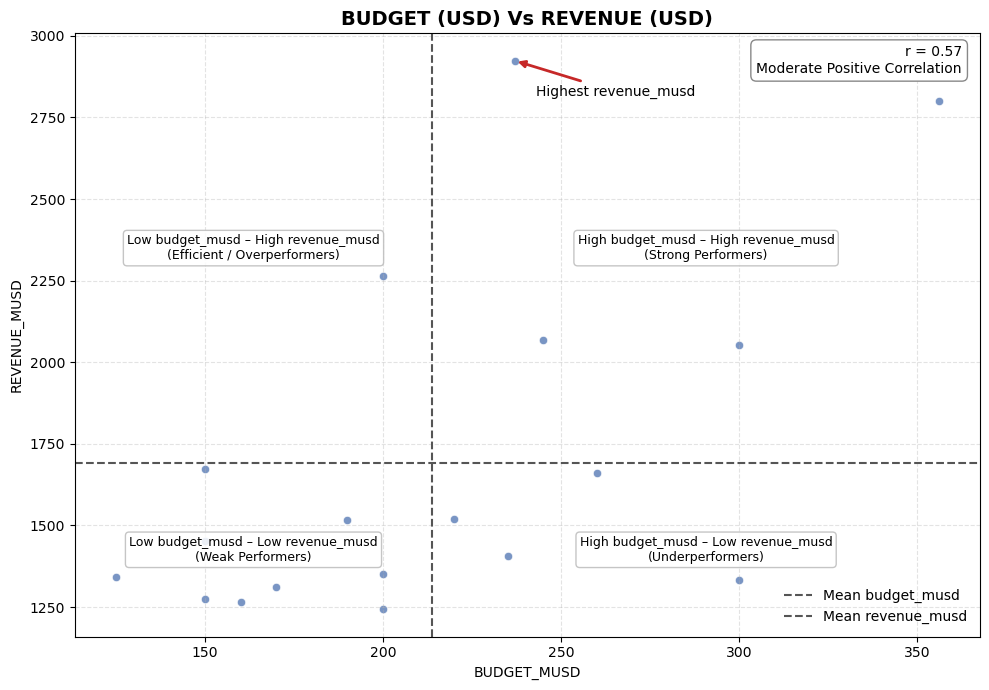

In [60]:
#Calls the trend visuals function
trendVisuals(data=rev_budget_pdf, column1="budget_musd", column2="revenue_musd", title="BUDGET (USD) Vs REVENUE (USD)")

**Key insight**

- Higher budgets generally lead to higher revenues, but with significant exceptions.

#### **POPULARITY VS RATING**

In [61]:
#Extracts the popularity and vote average from the pyspark dataFrame and converts it to a pandas dataFrame
pop_rating_pdf = (
    movie_data
    .select("popularity", "vote_average")
    .filter(
        (F.col("popularity").isNotNull()) &
        (F.col("vote_average").isNotNull()) &
        (F.col("vote_count") >= 10)
    )
    .toPandas()
)


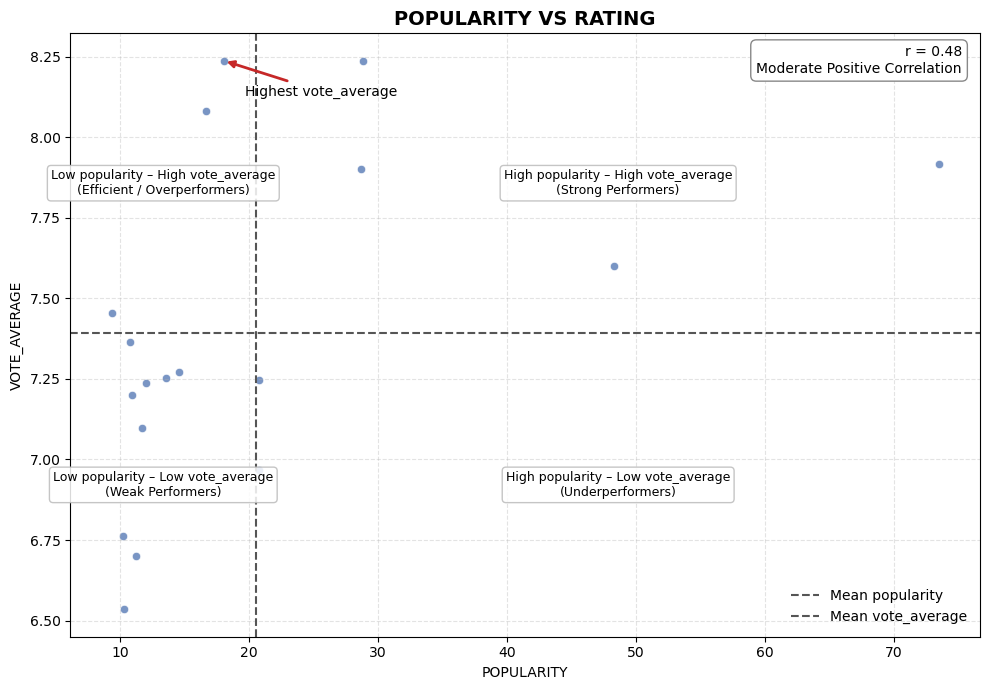

In [62]:
#Calls the trend visuals function
trendVisuals(data=pop_rating_pdf, column1="popularity", column2="vote_average", title="POPULARITY VS RATING")

**Key insight**

- Popular movies tend to be better rated, but quality alone does not guarantee popularity.

#### **YEARLY TRENDS**

In [63]:
#Extracts the release date and revenue from sparks dataFrame and converts it to a pandas dataFrame
yearly_revenue_pdf = (
    movie_data
    .select("release_date", "revenue_musd")
    .filter(
        (F.col("release_date").isNotNull()) &
        (F.col("revenue_musd").isNotNull())
    )
    .toPandas()
)

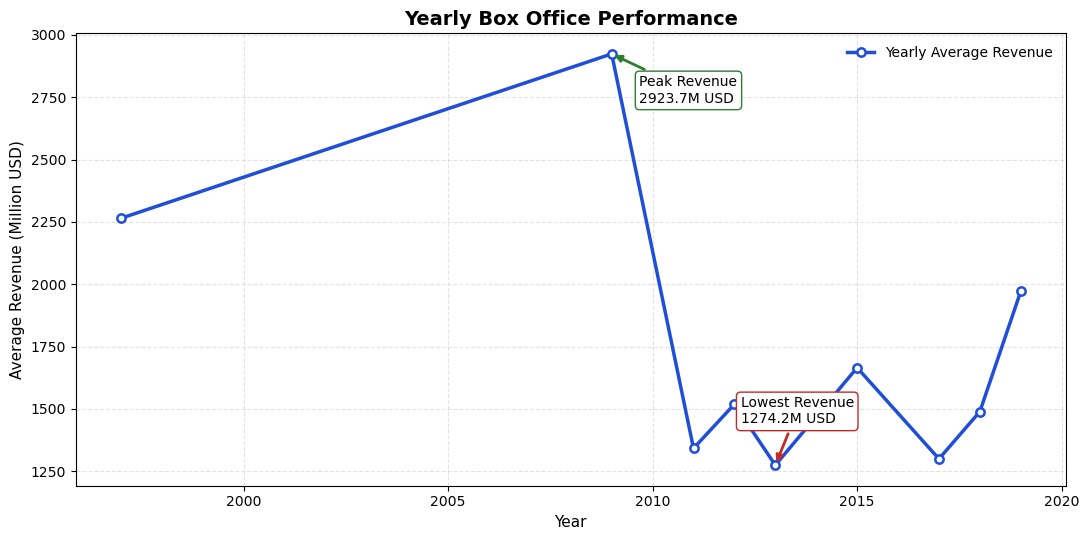

In [64]:
#Calls the plot yearly trends
plot_yearly_box_office_trends(yearly_revenue_pdf)

**Key insights**

- Average revenue steadily increased from the late 1990s to 2009, peaking at approximately $2.9B.

- Sharp decline around 2011–2013

- Revenue drops dramatically, hitting the lowest point in 2013 (~$1.27B).

- Revenues fluctuate but trend upward again by 2019, showing resilience rather than collapse.

#### **FRANCHISE AND STANDALONE COMPARISON**

In [65]:
#Extracts the fields for plotting the graph
franchise_pdf = (
    movie_data
    .withColumn(
        "movie_type",
        F.when(F.col("belongs_to_collection").isNotNull(), "Franchise")
         .otherwise("Standalone")
    )
    .groupBy("movie_type")
    .agg(
        F.avg("revenue_musd").alias("revenue_musd"),
        F.avg("budget_musd").alias("budget_musd"),
        F.avg("vote_average").alias("vote_average"),
        F.avg("ROI").alias("ROI")
    )
    .toPandas()
)


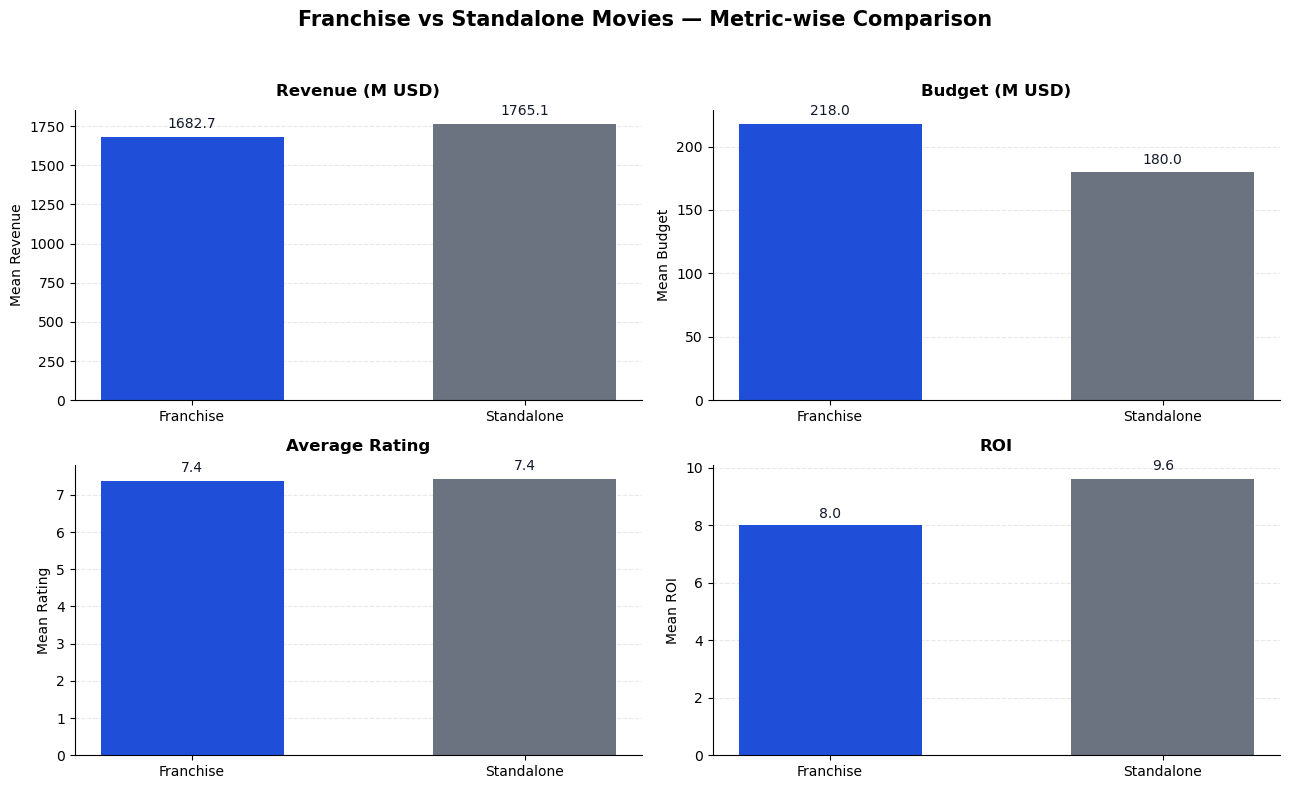

In [66]:
#Calls the function to plot the graph
plot_franchise_vs_standalone_metrics(franchise_pdf)

**Key Insights**

- Standalone films actually generate slightly higher mean revenue ($1,765.1M) compared to franchise films ($1,682.7M)

- Franchise films require significantly higher budgets ($218M) compared to standalone films ($180M)
This represents about 21% more investment for franchise productions

- Standalone films deliver substantially better ROI (9.6) compared to franchise films (8.0)

- Both categories receive identical average ratings (7.4), indicating comparable audience satisfaction regardless of franchise status

### **ROI DISTRIBUTION BY GENRE**

In [67]:
#Extracts the data needed for the plotting
roi_genre = (
    movie_data
    .groupBy("genres")
    .agg(F.expr("percentile_approx(roi, 0.5)").alias("median_roi"))
)

# Pandas (small, safe)
roi_genre_pdf = roi_genre.toPandas()


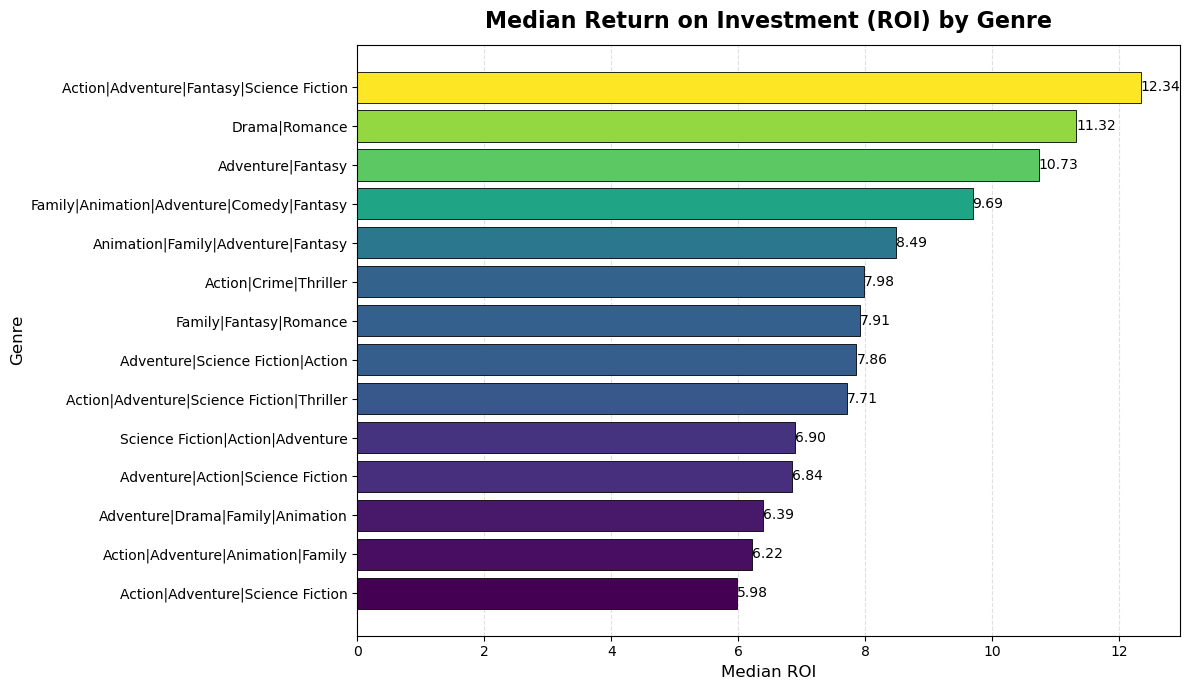

----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 53090)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/opt/conda/lib/python3.11/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/opt/conda/lib/python3.11/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/opt/conda/lib/python3.11/socketserver.py", line 755, in __init__
    self.handle()
  File "/usr/local/spark/python/pyspark/accumulators.py", line 295, in handle
    poll(accum_updates)
  File "/usr/local/spark/python/pyspark/accumulators.py", line 267, in poll
    if self.rfile in r and func():
                           ^^^^^^
  File "/usr/local/spark/python/pyspark/accumulators.py", line 271, in accum_updates
    num_updates =

In [ ]:
#Calls the function
plot_roi_by_genre(roi_genre_pdf)

**Key Insights**

- Action/Adventure/Fantasy/Science Fiction leads with an impressive 12.34 median ROI

- Drama/Romance comes in second at 11.32

- Adventure/Fantasy ranks third at 10.73

- Multi-genre combinations (especially those including Action, Adventure, and Fantasy/Science Fiction) tend to perform better financially